# Исследование надёжности заёмщиков — анализ банковских данных

## Описание проекта

**Заказчик**: кредитный отдел банка. 

**Данные**: статистика о платёжеспособности клиентов.

**Бизнес-цель**: определить влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. 

**Задача**: провести исследование, которое будет учтено при построении модели кредитного скоринга.

## Импорт библиотек, считывание и первичный анализ данных

In [1]:
# Установим на сервер библиотеки, которые будут использоваться в проекте, но отсутствуют
!pip install missingno -q
!pip install sweetviz -q
# Библиотека pandas-profiling не всегда устанавливается стабильно, поэтому принудительно зададим стабильные версии
!pip install pandas_profiling==1.4.1 -q
!pip install pandas==0.25.3 -q

Все три устанавливаемые библиотеки (pandas_profiling, missingno, sweetviz) помогут в проведении более тщательного EDA анализа. Исследовательский анализ можно делать и с помощью ручного вызова функций дефолтных библиотек. Предлагаемые библиотеки выбраны для максимизации комфорта презентации результатов анализа бизнес-пользователям.

In [2]:
# Импортируем требуемые для работы библиотеки

import pandas as pd
import numpy as np
import pandas_profiling
import sweetviz as sv
from sklearn.impute import MissingIndicator
from pymystem3 import Mystem
import missingno as msno 

# Установка настроек для отображения всех колонок и строк при печати
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Настройки для печати нескольких выводов данных в одной ячейке
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Игнорирование предупреждения об ошибках
import warnings
warnings.filterwarnings('ignore')

# библиотеки работы с файлами
from pathlib import Path
import os
from urllib.request import urlretrieve

In [3]:
# Напишем функцию, которая проверяет наличие локального файла, в случае отсутствия - скачивает по ссылке
def get_file(file_name, url):
        
    if not os.path.exists(file_name):
        print(file_name,'Файл не найден и будет скачиваться по сети.')
        urlretrieve(url,file_name)

In [4]:
# Считываем файл с данными
Path('datasets').mkdir(parents=True, exist_ok=True)
urls = {'data':('datasets\\data.csv', 'https://code.s3.yandex.net/datasets/data.csv')}
[get_file(*urls[k]) for k in urls]

df = pd.read_csv(urls['data'][0])

[None]

In [5]:
# Запускаем библиотеку pandas_profiling для проведения исследовательского анализа данных
pandas_profiling.ProfileReport(df)

Number of variables,12
Number of observations,21525
Total Missing (%),1.7%
Total size in memory,2.0 MiB
Average record size in memory,96.0 B
Numeric,6
Categorical,5
Boolean,1
Date,0
Text (Unique),0
Rejected,0


С помощью инструмента pandas_profiling можно быстро ознакомиться с основными характеристиками изучаемого набора данных: увидеть информацию о типах данных, пропусках, дубликатах, распределениях, корреляции признаков. На основании полученной с помощью данного инструмента информации можно определиться в какую сторону следует продолжить анализировать данные для получения более подробного понимания природы той или иной особенности данных. Pandas profiling не панацея, но упрощает EDA анализ. 

In [6]:
# Визуализируем количество пропусков в данных
msno.matrix(df)

<AxesSubplot:>

Данный инструмент позволяет на визуальном уровне подсветить интересную особенность рассматриваемого набора данных - пропуски в колонках days_employed и total_income расположены идентично - т.е. предположительно в этих признаках данные отсутствуют для одних и тех же наблюдений. Для того чтобы понять природу данного явления, следует проанализировать данные наблюдения более тщательно.  

In [7]:
# Посмотрим более подробно на наблюдения, в которых присутствуют пропуски в колонках days_employed и total_income
print('Количество позиций, у которых одновременно NaN в days_employed и total_income:')
df[(df['days_employed'].isnull())&(df['days_employed'].isnull())]['income_type'].shape[0]

Количество позиций, у которых одновременно NaN в days_employed и total_income:


2174

Данный результат подтверждает предположение, сделанное на основании визуального анализа - все пропуски имеющиеся в признаке days_employed находятся ровно в тех же наблюдениях, что и пропуски в признаке total_income. Попробуем выявить клиенты каким типом занятости и уровнем образования решили не заполнять о себе данную информацию.

In [8]:
print('Виды типов занятости клиентов, по которым отсутствует информация в days_employed и total_income:')
df[(df['days_employed'].isnull())&(df['days_employed'].isnull())]['income_type'].value_counts()

Виды типов занятости клиентов, по которым отсутствует информация в days_employed и total_income:


сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

In [9]:
print('Виды типов по уровню образования клиентов, по которым отсутствует информация в days_employed и total_income:')
df[(df['days_employed'].isnull())&(df['days_employed'].isnull())]['education'].value_counts()

Виды типов по уровню образования клиентов, по которым отсутствует информация в days_employed и total_income:


среднее                1408
высшее                  496
СРЕДНЕЕ                  67
Среднее                  65
неоконченное высшее      55
Высшее                   25
ВЫСШЕЕ                   23
начальное                19
Неоконченное высшее       7
НЕОКОНЧЕННОЕ ВЫСШЕЕ       7
Начальное                 1
НАЧАЛЬНОЕ                 1
Name: education, dtype: int64

Как видно из результатов анализа, категория занятости "сотрудник" достаточно размыта и не дает полного понимания причин, по которым клиенты не хотят указывать уровень заработной платы. Т.к. большая часть рассматриваемых клиентов имеет средний уровень образования, есть предположение, что должности, на которых работают данные специалисты имет не очень высокий уровень заработной платы, либо клиент имеет малый стаж. В совокупности все эти факторы могут свидетельствовать о принадлежности клиента к группе с высоким риском невозврата кредита.

In [10]:
# Посмотрим на типы данных признаков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Признаки `total_income` и `days_employed` имеют тип данных float. Касательно признака `total_income` это приводит к большому разбросу значений и усложняет анализ. Признак `days_employed` должен хранить информацию в днях, а значит текущий тип данных некорректен. 

In [11]:
# Проверим различаются ли категории признаков family_status и family_status_id
df.groupby(['family_status', 'family_status_id'])['debt'].agg('count').reset_index()

,family_status,family_status_id,debt
0,Не женат / не замужем,4,2813
1,в разводе,3,1195
2,вдовец / вдова,2,960
3,гражданский брак,1,4177
4,женат / замужем,0,12380


Категории признаков совпадают, а значит можно рассматривать вопрос об исключении одного из признаков, который менее информативен.

In [12]:
# Проверим различаются ли категории признаков education и education_id
df.groupby(['education', 'education_id'])['debt'].agg('count').reset_index()

,education,education_id,debt
0,ВЫСШЕЕ,0,274
1,Высшее,0,268
2,НАЧАЛЬНОЕ,3,17
3,НЕОКОНЧЕННОЕ ВЫСШЕЕ,2,29
4,Начальное,3,15
5,Неоконченное высшее,2,47
6,СРЕДНЕЕ,1,772
7,Среднее,1,711
8,УЧЕНАЯ СТЕПЕНЬ,4,1
9,Ученая степень,4,1


В связи с проблемой регистра значений в признаке education вывод о совпадении пизнаков не столь очевиден, но более детальный анализ так же подстверждает, что признаки идентичны и следует оставить только один из них. 

In [13]:
# Посмотрим на дубликаты в данных
df.loc[df.duplicated()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,NaN,41,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,покупка жилья для семьи
4182,1,NaN,34,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,NaN,свадьба
4851,0,NaN,60,среднее,1,гражданский брак,1,F,пенсионер,0,NaN,свадьба
5557,0,NaN,58,среднее,1,гражданский брак,1,F,пенсионер,0,NaN,сыграть свадьбу
7808,0,NaN,57,среднее,1,гражданский брак,1,F,пенсионер,0,NaN,на проведение свадьбы
8583,0,NaN,58,высшее,0,Не женат / не замужем,4,F,пенсионер,0,NaN,дополнительное образование
9238,2,NaN,34,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,покупка жилья для сдачи
9528,0,NaN,66,среднее,1,вдовец / вдова,2,F,пенсионер,0,NaN,операции со своей недвижимостью
9627,0,NaN,56,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,операции со своей недвижимостью
10462,0,NaN,62,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,покупка коммерческой недвижимости


- во всех строках пропущены значения `days_employed` и `total_income`, 
- все строки имеют 0 в целевом признаке `debt`, 
- в признаке `gender` преимущественно значение 'F', 
- в признаке `famyly_status` преобладают значения 'женат / замужем', 'гражданский брак'.   

Данные наблюдения не позволяют сделать однозначных выводов о причинах появления дублирующих значений.

In [14]:
# Посмотрим на наблюдения, у которых в колонке dob_years значение 0
df[df['dob_years']==0].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
99,0,346541.618895,0,Среднее,1,женат / замужем,0,F,пенсионер,0,71291.522491,автомобиль
149,0,-2664.273168,0,среднее,1,в разводе,3,F,сотрудник,0,70176.435951,операции с жильем
270,3,-1872.663186,0,среднее,1,женат / замужем,0,F,сотрудник,0,102166.458894,ремонт жилью
578,0,397856.565013,0,среднее,1,женат / замужем,0,F,пенсионер,0,97620.687042,строительство собственной недвижимости
1040,0,-1158.029561,0,высшее,0,в разводе,3,F,компаньон,0,303994.134987,свой автомобиль


В рассматриваемых строках нет ярковыраженного паттерна, который позволил бы сделать предположение о "правильном" значении для данного признака, а это означает, что признак не удастся восстановить не исказив данные.

### Вывод

Представлен набор данных размером 21525 наблюдений, которые описываются 12 признаками. 

**Типы данных**:

- `total_income` имеет тип данных float, что дает большой разброс значений и усложняет анализ информации. Для исправления предлагается округлить значения путем замены типа данных на int. 

- `days_employed` имеет тип данных float, что некорректно для данного типа информации (общепринято показатель имеющий единицу измерения 'день' отображать целочисленно). 

Для замены типов данных будет использован метод as_type('int'). Но, следует учесть, что данный метод не получится использовать, если в колонке имеются значения NaN. 

**Дубликаты**:

- в наборе данных имеется 54 дубликата строк. Причиной дублей могут быть как обстоятельства, которые приводят к тому, что люди пробуют подавать несколько заявок, так и технический сбой, который привел к дублированию выборочных позиций. Но, т.к. у нас нет уникального идентификатора позиций, высказанные ранее предположения могут быть ошибочными, а дубли случайными. 

- признаки `family_status` и `family_status_id` идентичны
- признаки `education` и `education_id` идентичны
Для бизнес-анализа предпочтительнее оставить признаки `family_status` и `education`. Если бы речь шла о подготовке данных для последующего построения моделей машинного обучения, то предпочтение лучше отдать признакам `family_status_id` и `education_id`

**Лемматизация**:

- `purpose` - многовариантное написание одинаковых по сути целей. Требуется категоризация. Для реализации будет использоваться библиотека pymystem3, которая обрабатывает строки, создавая списки лемм. Из получившихся списков лемм по ключевым словам будет произведено отнесение к той или иной категории.

**Категоризация**:

- `income_type`, `dob_years`, `children`, `total_income`, `days_employed`

В данных признаках слишком много вариантов значений, что усложняет как бизнес-анализ, так и последующее моделирование. 

В решении будет использовано два подхода по категоризации данных: 
- отнесение к категориям на основании бизес-логики
- автоматическое разделение по квантилям (в случае если полученное разделение не будет противоречить бизнес-логике)

По возможности следует придерживаться ограничения не более 10 категорий на признак. Т.к. в рамках проекта предполагается анализ, результаты которого будут демонстрироваться бизнесу - названия категорий должны быть понятными для бизнеса. Для целей дальнейшего прототипирования потребуется произвести дополнительную обработку категориальных данных (OHE, label encoding, другое)


**Укрупнение категорий**:

- `income_type` - содержит малочисленные категории 'безработный', 'предприниматель', 'в декрете', 'студент'. Предлагается объединить данные категории в категорию 'другое'	

- `gender` - имеется одно значение типа 'XNA'. Предположительно ошибка ввода. Предлагается заменить данное значение на малочисленную категорию данных 'M'.

- `education` - малочисленную категорию 'ученая степень' объединить с категорией 'высшее'

Данные меры оправданы и возможны только тогда или до тех пор, пока данные малочисленные категории остаются малочисленными при добавлении данных (на новых данных). В случае, если категории изменяются в процентном соотношении, и перестают быть малочисленными - данное объединение стоит отменять. 

**Дополнительные проблемы в данных**:

- `days_employed` - Информация представлена в часах. Требуется перевести в дни. Имеются отрицательные значения. Предполагаемая причина - некорректный ввод данных или сбой в процессе получения данных. Требуется обозначить данную проблему коллегам, которые отвечают за выгрузку данных. 
- `children` минимальное значение -1, максимальное 20. Предположительно ошибка ввода данных. Предлгается заменить -1 на 1, 20 на 2
- `dob_years` - 101 наблюдение со значением 0. Ошибка данных. Т.к. не удалось восстановить какое значение могло бы считаться корректным, предлагается удалить данные строки.
- `education` - многовариантное заполнение одинаковых типов образования. Приведение к нижнему регистру снимет проблему.

**Пропуски в данных**:
- В признаках `days_employed` и `total_income` выявлено одинаковое количество пропусков в размере 2174 наблюдений 
Пропуски в данных признаках присутствуют в идентичных наблюдениях. Признаки имеют связанный характер. Предполагаемая причина пропусков - осознанное незаполнение клиентами данной информации по причине принадлежнойсти к категории с высоким риском невозврата кредита. 

В качестве работы с пропущенными значениями может быть несколько стратегий:
1. удаление строк с пропусками, если их не более 10% от общего количества данных (в нашем случае 10.1%). Данный способ не очень предпочтителен, т.к. приведет к потере информации о важном типе клиентов - которые укрывают от банка важную для принятия решения информацию.
2. заполение пропусков статистическим значением, например, медианой. Данный способ тоже имеет минусы, т.к. это может исказить данные, а соответственно и выводы, которые на основании этих данных делаются. 

Предлагается альтернативное решение: 
- для сохранения информации о наличии пропусков создать признак-флаг (тип булево, True - в интересующей колонке был пропуск). т.к. в нашем случае пропуски идентичны, то можно ограничиться одной колонкой с флагом на оба признака (здесь следует учитывать, что если создать колонку с "флагом" на каждый признка, то они будут иметь высокую кореляцию, что тоже плохо для этапа моделирования). В дальнейшем, при построении моделей машинного следует уделять внимание поведению моделей на признак-флаг - если данный признак будет иметь высокую важность, значит принципу заполнения пропусков надо уделить большее внимание. 
- заполнить пропуски медианным значением в зависимости от категории строки с пропуском. 

## Предобработка данных

### Устранение дубликатов данных

In [15]:
# Сделаем проверку дубликатов до их устранения
print("Количество дубликатов до удаления:", df.duplicated().sum())

# Используем метод drop_duplicated
df = df.drop_duplicates()

# Сделаем контрольную проверку, чтобы убедиться в коректности действий
print("Количество дубликатов после удаления:", df.duplicated().sum())

Количество дубликатов до удаления: 54
Количество дубликатов после удаления: 0


In [16]:
# Удалим дублирующие колонки family_status_id и education_id
df = df.drop(['family_status_id', 'education_id'], axis=1)

df.head(2)

,children,days_employed,dob_years,education,family_status,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,женат / замужем,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,женат / замужем,F,сотрудник,0,112080.014102,приобретение автомобиля


### Устранение выявленных проблем в данных

In [17]:
# В колонке children избавимся от отрицательных значений путем взятия модуля, заменим значения 20 на 2
df['children'] = df['children'].abs()
df['children'] = df['children'].replace(20, 2)

df['children'].value_counts()

0    14107
1     4856
2     2128
3      330
4       41
5        9
Name: children, dtype: int64

In [18]:
# В колонке gender заменим значение 'XNA' на 'M'
df['gender'] = df['gender'].replace('XNA', 'M')

df['gender'].value_counts()

F    14189
M     7282
Name: gender, dtype: int64

In [19]:
# Удалим из набора данных наблюдения, у которых в колонке dob_years значение 0
df = df[df['dob_years']!=0]

In [20]:
# В колонке days_employed избавимся от отрицательных значений путем взятия модуля и переведем часы в дни
df['days_employed'] = df['days_employed'].abs()
df['days_employed'] = df['days_employed']/24

In [21]:
# Приведем к нижнему регистру значения в признаке family_status
df['family_status'] = df['family_status'].str.lower()

### Заполнение пропусков в данных

In [22]:
# Напишем функцию для создания признака-флага 
# На вход принимает признак у которого есть пропуски
# Результат - новая колонка со значением True на месте пропуска в исходной колонке
def flag(feature, feature_name):
        
    miss_i = MissingIndicator()
    miss_i.fit(df[[feature]])
    df[feature_name] = miss_i.transform(df[[feature]])

# Делаем вызов функции flag для признака days_employed (актуально и для total_income)
flag('days_employed', 'missing_d_empl/t_inc') 

df.head(2)

,children,days_employed,dob_years,education,family_status,gender,income_type,debt,total_income,purpose,missing_d_empl/t_inc
0,1,351.569709,42,высшее,женат / замужем,F,сотрудник,0,253875.639453,покупка жилья,False
1,1,167.700156,36,среднее,женат / замужем,F,сотрудник,0,112080.014102,приобретение автомобиля,False


In [23]:
# Напишем функцию, которая заменяет пропуски на медианное значение в зависимости от категории строки с пропуском
def replace_nan(column_name, income_type):
    median = df[df['income_type'] == income_type][column_name].median()
    df.loc[(df[column_name].isnull()) & (df['income_type'] == income_type), column_name] = median

In [24]:
# Формируем список уникальных категорий, по строкам в которых есть NaN
# Идем циклом по сформированному списку и вызываем функцию замены пропусков для столбцов 'total_income' и 'days_employed'
list_for_replace_nan = df[df['total_income'].isnull()]['income_type'].unique()
for column in ['total_income', 'days_employed']:
    for i in list_for_replace_nan:
        replace_nan(column, i)
        
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21370 entries, 0 to 21524
Data columns (total 11 columns):
children                21370 non-null int64
days_employed           21370 non-null float64
dob_years               21370 non-null int64
education               21370 non-null object
family_status           21370 non-null object
gender                  21370 non-null object
income_type             21370 non-null object
debt                    21370 non-null int64
total_income            21370 non-null float64
purpose                 21370 non-null object
missing_d_empl/t_inc    21370 non-null bool
dtypes: bool(1), float64(2), int64(3), object(5)
memory usage: 1.8+ MB


### Корректировка типов данных

In [25]:
# Изменим тип данных для признаков total_income и days_employed с float -> int
df['total_income'] = df['total_income'].astype('int')
df['days_employed'] = df['days_employed'].astype('int')

### Категоризация

In [26]:
# Напишем функцию для лемматизации и последующей категоризации значений признака purpose 
def lemmatize(string):
    lemma = m.lemmatize(string)
    if 'свадьба' in lemma:
        return  'свадьба'
    elif 'недвижимость' in lemma or 'жилье' in lemma:
        return  'недвижимость'
    elif 'автомобиль' in lemma:
        return  'автомобиль'
    elif 'образование' in lemma:
        return  'образование'
    return 'другое'

# Делаем вызов функции lemmatize
m = Mystem() 
df['purpose'] = df['purpose'].apply(lemmatize)

df['purpose'].value_counts()

недвижимость    10767
автомобиль       4286
образование      3996
свадьба          2321
Name: purpose, dtype: int64

In [27]:
# Приведем к нижнему регистру значения в признаке education
df['education'] = df['education'].str.lower()
# Значение 'ученая степень' на 'высшее'
df['education'] = df['education'].replace('ученая степень', 'высшее')

df['education'].value_counts()

среднее                15124
высшее                  5222
неоконченное высшее      742
начальное                282
Name: education, dtype: int64

In [28]:
# В колонке income_type заменим значения 'безработный', 'предприниматель', 'в декрете', 'студент' на 'другое'
df['income_type'] = df['income_type'].replace(['безработный','предприниматель','студент','в декрете'], 'другое')

df['income_type'].value_counts()

сотрудник      11036
компаньон       5060
пенсионер       3817
госслужащий     1451
другое             6
Name: income_type, dtype: int64

In [29]:
# Реализуем категоризацию данных в колонке dob_years по квантилям на 3 категории: 'молодежь', 'средний возраст', 'пожилой возраст'
pd.qcut(df['dob_years'], 3).value_counts()

df['dob_years'] = pd.qcut(df['dob_years'], 3, labels=['молодежь', 'средний возраст', 'пожилой возраст'])

# Проверим получившиеся категории
df['dob_years'].value_counts()

(36.0, 50.0]      7576
(18.999, 36.0]    7139
(50.0, 75.0]      6655
Name: dob_years, dtype: int64

средний возраст    7576
молодежь           7139
пожилой возраст    6655
Name: dob_years, dtype: int64

In [30]:
# Напишем функцию для категоризации количества детей на 3 группы: 'нет детей', '1-3 ребенка', 'больше 3'
def group_children(children):
        if children == 0:
                return 'нет детей'
        if children <= 3:
                return '1-3 ребенка'
        return 'больше 3'

In [31]:
# Применяем функцию group_children к данным колонки children. 
df['children'] = df['children'].apply(group_children)

In [32]:
# Напишем функцию для категоризации дохода на 5 групп: низкий доход (0-75000), ниже среднего(76000-100000), 
# средний(101000-200000), выше среднего(201000-300000), высокий(301000 и более)
def group_total_income(total_income):
        if total_income <= 75000:
                return 'низкий доход'
        if total_income <= 100000:
                return 'ниже среднего'
        if total_income <= 200000:
                return 'средний'
        if total_income <= 300000:
                return 'выше среднего'
        return 'высокий'

In [33]:
# Применим функцию group_total_income к данным колонки total_income 
df['total_income'] = df['total_income'].apply(group_total_income)

In [34]:
# Напишем функцию для категоризации дохода на 6 групп:'не более 1 мес.', 'от 1 мес. до 1 года', '1-3 года',
#'3-5 лет', '5-15 лет', 'более 15 лет'
def group_days_employed(days_employed):
        if days_employed <= 30:
                return 'не более 1 мес.'
        elif 30 < days_employed <= 365:
                return 'от 1 мес. до 1 года'
        elif 365 < days_employed <= 365 * 3:
                return '1-3 года'
        elif 365 * 3 < days_employed <= 365 * 5:
                return '3-5 лет'
        elif 365 * 5 < days_employed <= 365 * 15:
                return '5-15 лет'
        return 'более 15 лет'

In [35]:
# Применим функцию group_days_employed к данным колонки total_income
df['days_employed'] = df['days_employed'].apply(group_days_employed)

df['days_employed'].value_counts()

от 1 мес. до 1 года    13218
не более 1 мес.         3907
более 15 лет            3819
1-3 года                 426
Name: days_employed, dtype: int64

In [36]:
# Проверим итоговый вид обработанных данных
df.head()

,children,days_employed,dob_years,education,family_status,gender,income_type,debt,total_income,purpose,missing_d_empl/t_inc
0,1-3 ребенка,от 1 мес. до 1 года,средний возраст,высшее,женат / замужем,F,сотрудник,0,выше среднего,недвижимость,False
1,1-3 ребенка,от 1 мес. до 1 года,молодежь,среднее,женат / замужем,F,сотрудник,0,средний,автомобиль,False
2,нет детей,от 1 мес. до 1 года,молодежь,среднее,женат / замужем,M,сотрудник,0,средний,недвижимость,False
3,1-3 ребенка,от 1 мес. до 1 года,молодежь,среднее,женат / замужем,M,сотрудник,0,выше среднего,образование,False
4,нет детей,более 15 лет,пожилой возраст,среднее,гражданский брак,F,пенсионер,0,средний,свадьба,False


### Вывод

- заполнены пропущенные значения (`total_income`, `days_employed`);
- заменен вещественный тип данных на целочисленный (`days_employed`);
- удалены дубликаты (54 строки-дубля, `family_status_id`, `education_id`);
- выделены леммы в значениях столбца с целями получения кредита;
- данные категоризированы (`purpose`, `education`, `income_type`, `dob_years`, `children`, `total_income`, `days_employed`).

## Исследовательский анализ данных


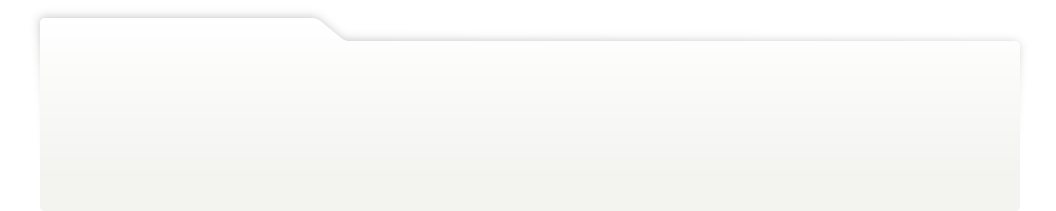
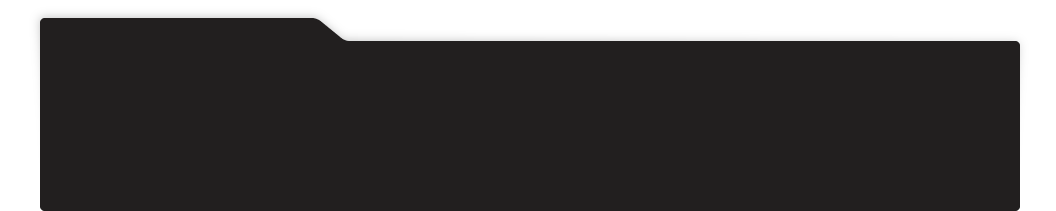
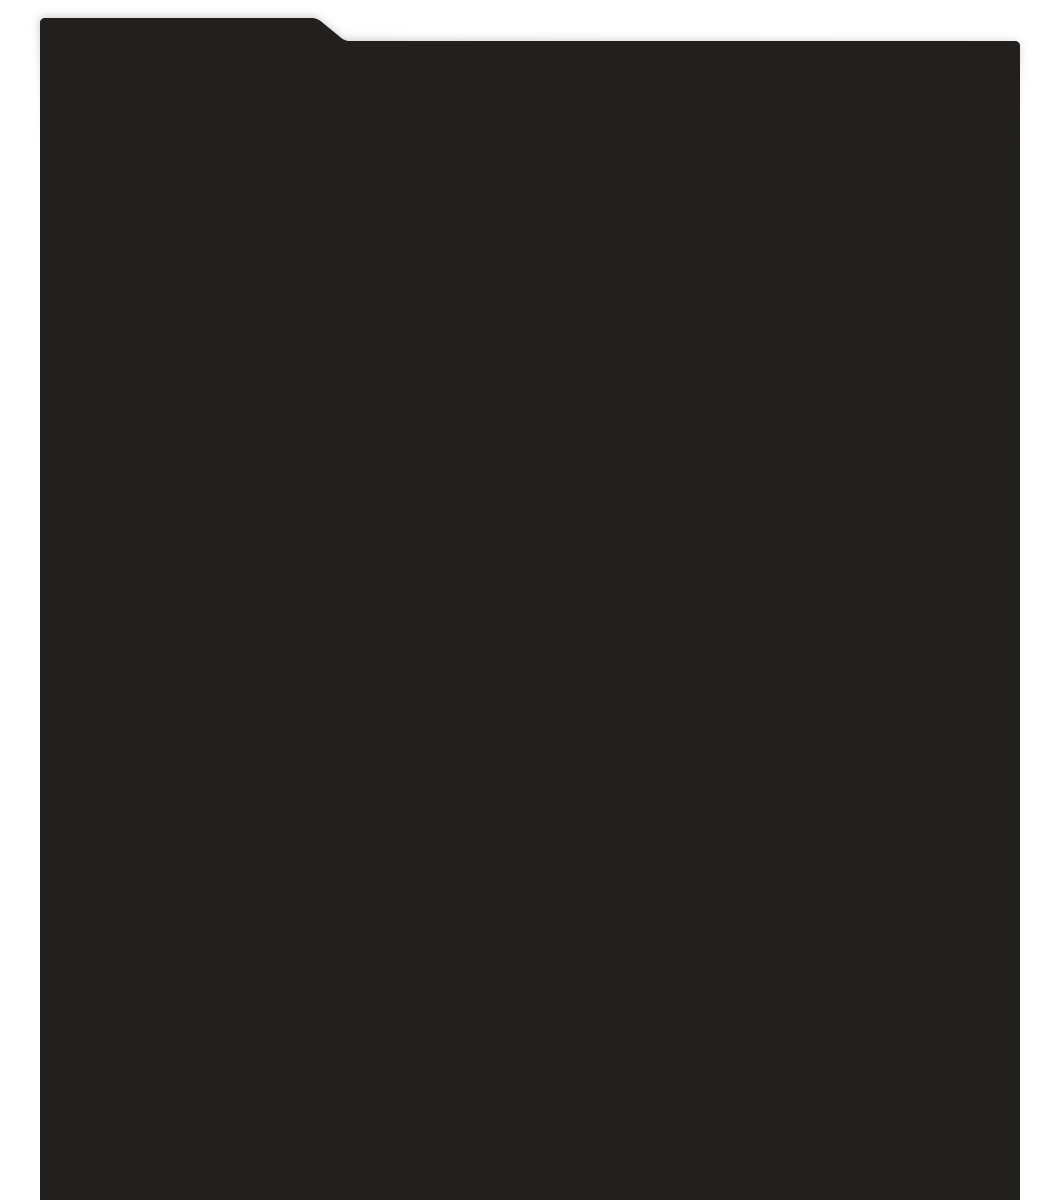
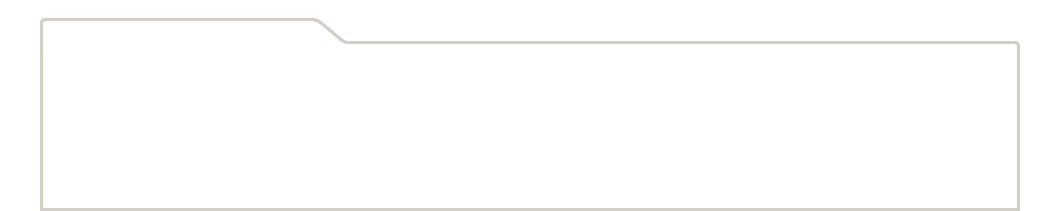
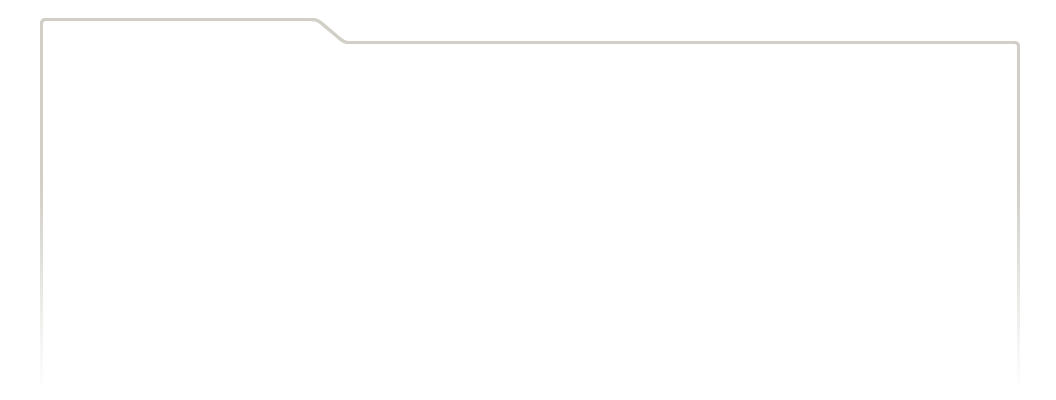
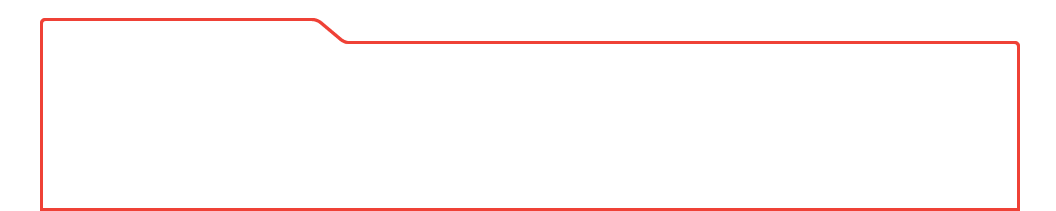
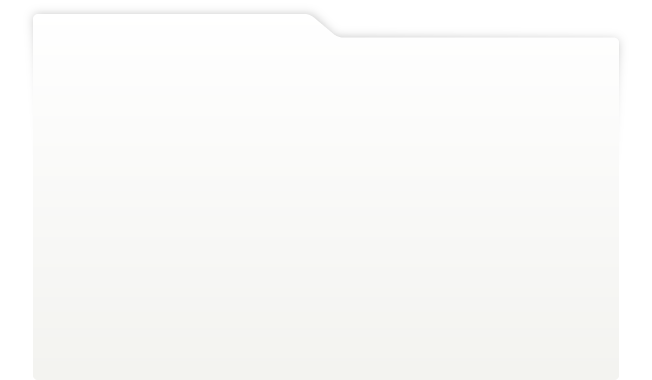
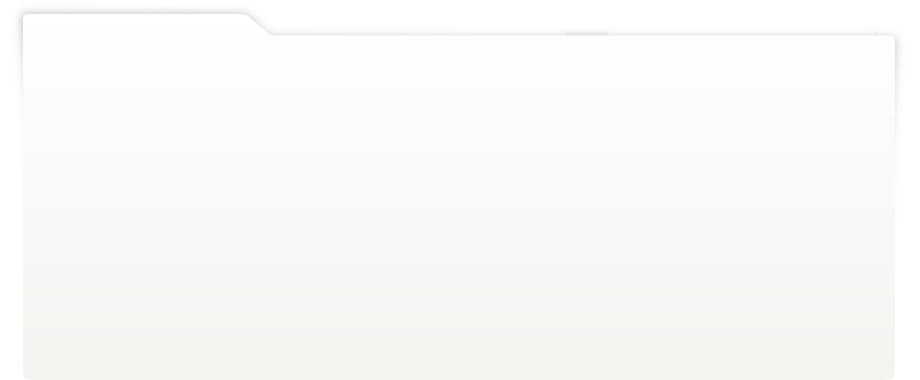
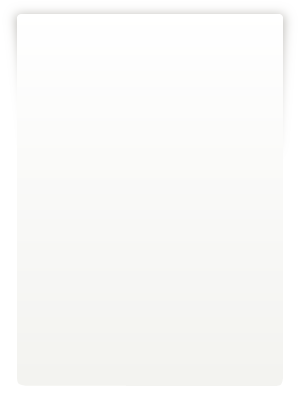
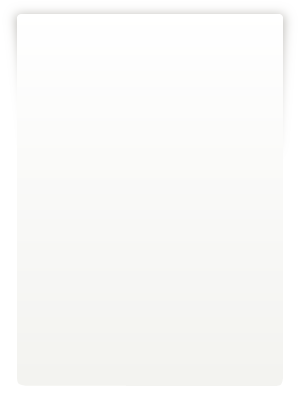
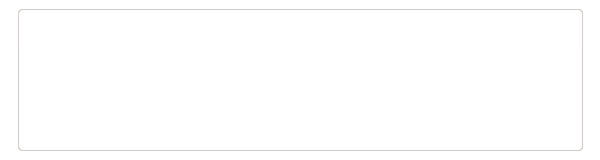
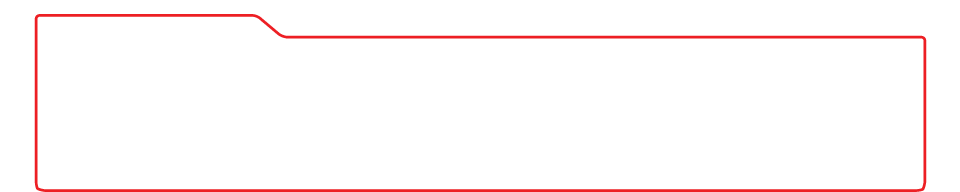
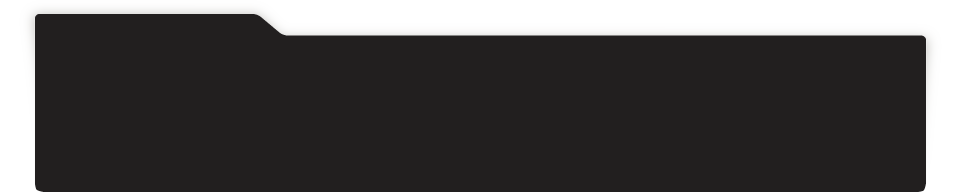
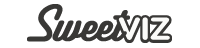
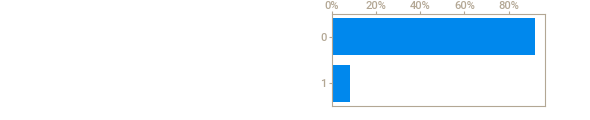
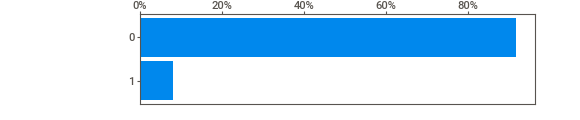
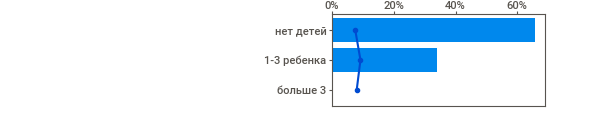
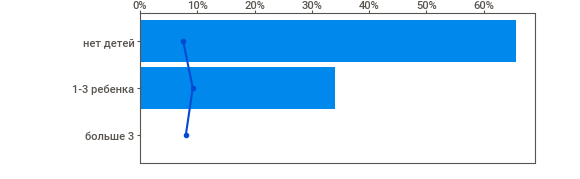
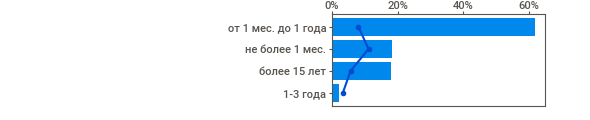
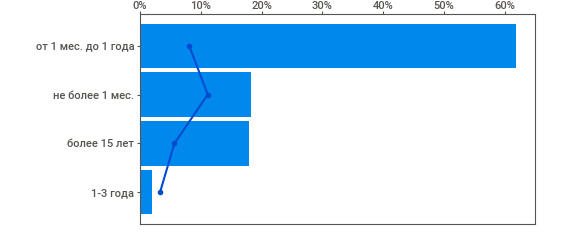
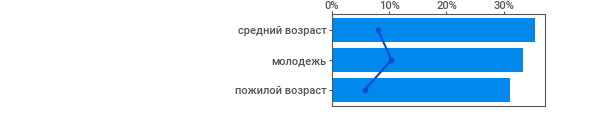
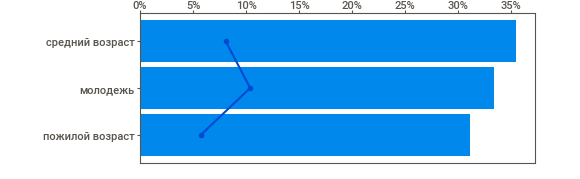
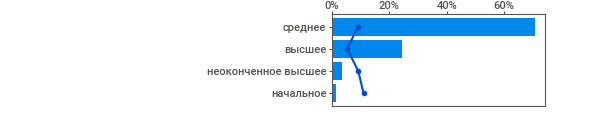
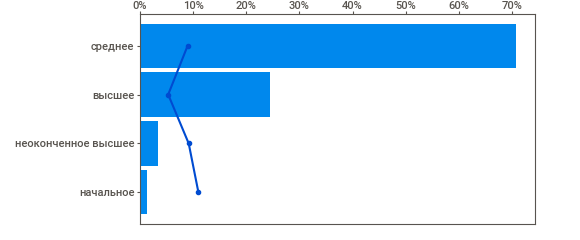
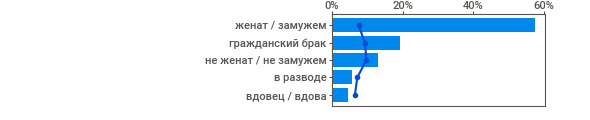
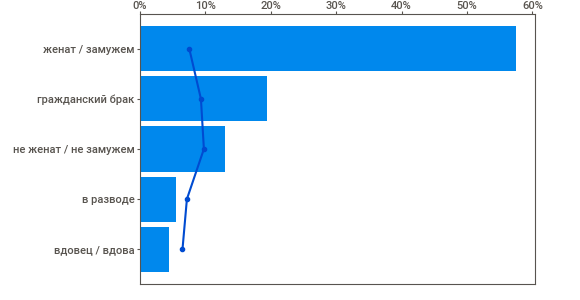
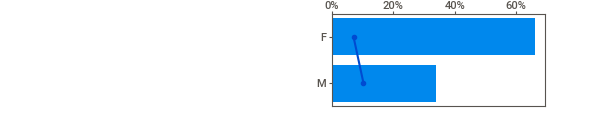
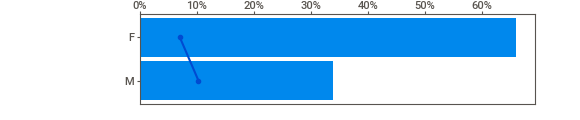
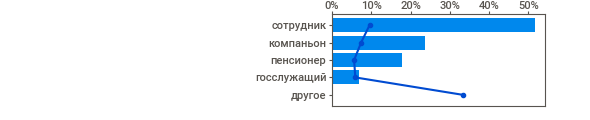
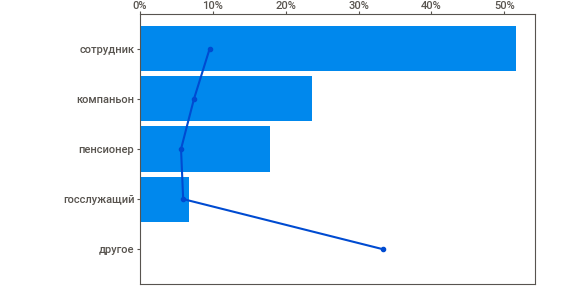
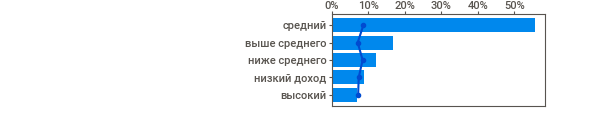
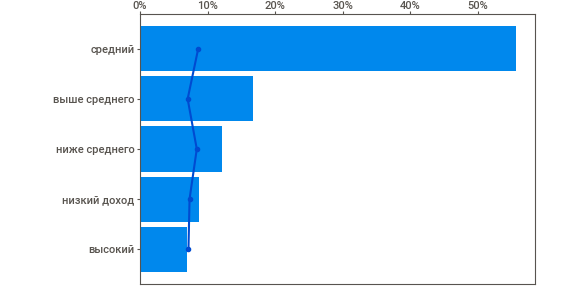
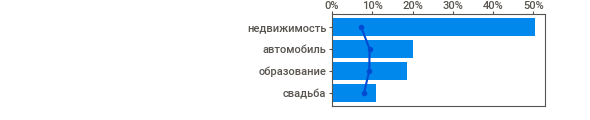
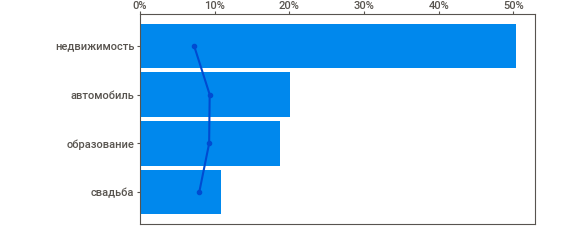
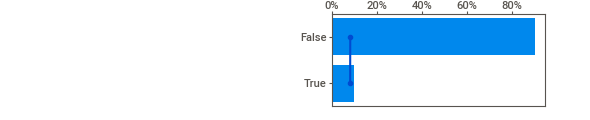
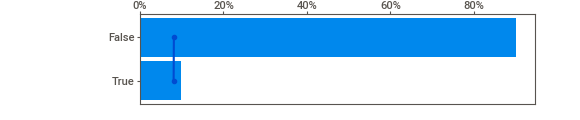
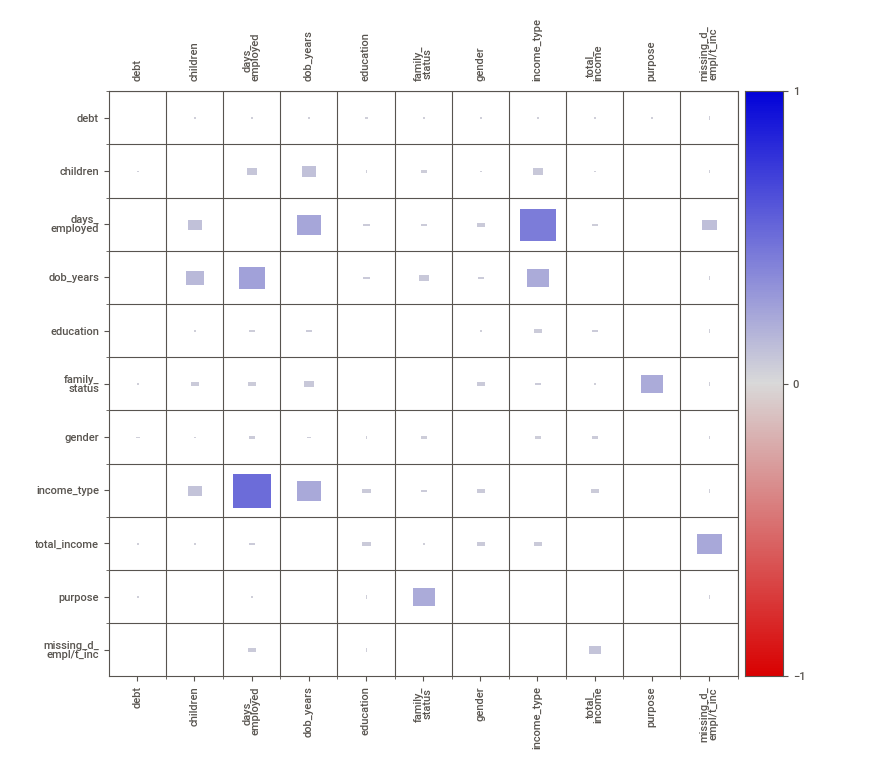
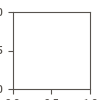

In [37]:
sv_report = sv.analyze(df, target_feat = 'debt')
sv_report.show_notebook() 

Инструмент sweetviz по своей функциональности похож на pandas_profiling и тоже используется для EDA анализа. Отличительной особенностью является возможность добавить целевой признак и визуализации с разделением набора данных на обучающий и тестовый наборы данных (будет актулаьно в проектах с моделированием). 

Проанализировав предоставленные отчеты по признакам можно составить следующий портрет пользователя, имеющего максимальный риск невозврата кредита для банка:  
- имеет 1-3 детей
- проработал не более 1 месяца
- по возрасту относится к категории "молодежь" (18-36 лет)
- начальное, среднее или неоконченное высшее образование
- семейный статус "не женат / не замужем" или "гражданский брак"
- мужской пол
- тип занятости "другое" ('безработный', 'предприниматель', 'студент' или 'в декрете')
- средний или ниже среднего заработок (от 75'000 до 200'000)
- цель взятия кредита "автомобиль" или "образование"

Результаты любых автоматических инструментов лучше перепроверить вручную.

In [38]:
# Напишем функцию по формированию сводной таблице и комментариев на ее основе
def pivot_table(column, text_pattern):
    pivot_table = df.pivot_table(index=[column], columns='debt', values='gender', aggfunc='count')
    pivot_table['debt_count'] = pivot_table[0] + pivot_table[1] 
    pivot_table['ratio'] = round(pivot_table[1]/pivot_table['debt_count'] * 100, 1)
    pivot_table.columns = ['debt_0', 'debt_1','debt_count','ratio']
    pivot_table = pivot_table.sort_values(by='ratio', ascending=False)
    
    for i in range(len(pivot_table)):
        print('{:.1f}% заёмщиков {} "{}" имели задолженность по кредиту'.format(pivot_table['ratio'][i], 
                                                                                text_pattern, 
                                                                                pivot_table.index[i]))
        
    return pivot_table

### Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [39]:
# Вызовем функцию pivot_table для признака children
children_pivot = pivot_table('children', 'c количеством детей')
children_pivot

9.2% заёмщиков c количеством детей "1-3 ребенка" имели задолженность по кредиту
8.0% заёмщиков c количеством детей "больше 3" имели задолженность по кредиту
7.5% заёмщиков c количеством детей "нет детей" имели задолженность по кредиту


,debt_0,debt_1,debt_count,ratio
children,,,,
1-3 ребенка,6611,671,7282,9.2
больше 3,46,4,50,8.0
нет детей,12980,1058,14038,7.5


### Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [40]:
# Вызовем функцию pivot_table для признака family_status
family_status_pivot = pivot_table('family_status', 'в статусе')
family_status_pivot

9.8% заёмщиков в статусе "не женат / не замужем" имели задолженность по кредиту
9.3% заёмщиков в статусе "гражданский брак" имели задолженность по кредиту
7.5% заёмщиков в статусе "женат / замужем" имели задолженность по кредиту
7.2% заёмщиков в статусе "в разводе" имели задолженность по кредиту
6.5% заёмщиков в статусе "вдовец / вдова" имели задолженность по кредиту


,debt_0,debt_1,debt_count,ratio
family_status,,,,
не женат / не замужем,2521,273,2794,9.8
гражданский брак,3756,386,4142,9.3
женат / замужем,11368,927,12295,7.5
в разводе,1100,85,1185,7.2
вдовец / вдова,892,62,954,6.5


### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [41]:
# Вызовем функцию pivot_table для признака total_income
total_income_pivot = pivot_table('total_income', 'с заработком')
total_income_pivot

8.6% заёмщиков с заработком "средний" имели задолженность по кредиту
8.4% заёмщиков с заработком "ниже среднего" имели задолженность по кредиту
7.3% заёмщиков с заработком "низкий доход" имели задолженность по кредиту
7.2% заёмщиков с заработком "высокий" имели задолженность по кредиту
7.0% заёмщиков с заработком "выше среднего" имели задолженность по кредиту


,debt_0,debt_1,debt_count,ratio
total_income,,,,
средний,10866,1023,11889,8.6
ниже среднего,2367,217,2584,8.4
низкий доход,1720,136,1856,7.3
высокий,1373,106,1479,7.2
выше среднего,3311,251,3562,7.0


### Как разные цели кредита влияют на его возврат в срок?

In [42]:
# Вызовем функцию pivot_table для признака purpose
purpose_pivot = pivot_table('purpose', 'с целью кредита на')
purpose_pivot

9.3% заёмщиков с целью кредита на "автомобиль" имели задолженность по кредиту
9.3% заёмщиков с целью кредита на "образование" имели задолженность по кредиту
7.9% заёмщиков с целью кредита на "свадьба" имели задолженность по кредиту
7.2% заёмщиков с целью кредита на "недвижимость" имели задолженность по кредиту


,debt_0,debt_1,debt_count,ratio
purpose,,,,
автомобиль,3886,400,4286,9.3
образование,3626,370,3996,9.3
свадьба,2137,184,2321,7.9
недвижимость,9988,779,10767,7.2


### Вывод

В резальтате ответа на поставленные бизнесом вопросы, вырисовывается понимание, что следует обратить внимание на клиентов с количеством детей 1-3, со средним и ниже уровнем дохода, отношения которых не подтверждены официальным статусом и берущих кредиты на автомобиль или с целью получения образования. 

На основании отчета полученного с помощью инструмента sweetviz к портрету пользователя добавились еще два немаловажных нюанса: чаще всего, клиентами не возвращающими кредит являются молодые люди, с непродолжительным рабочим стажем и не имеющим высшее образование. 

Возможно, это молодые люди, которые пока имеют слабый опыт в вопросах финансовой грамотности и им не следует усложнять свою жизнь взятием кредитов. Для банка это серьезный повод совместить свои интересы и заботу о гражданах и для клиентов с таким портретом, отказать в выдаче кредита. 

## Вывод

Проанализирован набор данных о статистика о платёжеспособности клиентов кредитного отдела банка объемом 21525 наблюдений, которые описываются 12 признаками.

Данные имели множество артефактов, которые были устранены. Также для удобства дальнейшего анализа была произведена категоризация значений признаков: 
- заполнены пропущенные значения;
- заменен некорректный тип данных;
- удалены дубликаты;
- произведена лемматизация.

В качестве результата исследования составлен портрет типичного пользователя, имеющего максимальный риск невозврата кредита для банка:  
- имеет 1-3 детей
- проработал не более 1 месяца
- по возрасту относится к категории "молодежь" (18-36 лет)
- начальное, среднее или неоконченное высшее образование
- семейный статус "не женат / не замужем" или "гражданский брак"
- мужской пол
- тип занятости "другое" ('безработный', 'предприниматель', 'студент' или 'в декрете')
- средний или ниже среднего заработок (от 75'000 до 200'000)
- цель взятия кредита "автомобиль" или "образование"

Предположительно, клиенты с данными характеристиками имеют большую финансовую нагрузку и не очень большие финансовые возможности, что не позволяет им выполнять обязательства перед банком в срок, что для банка делает такую категорию граждан и цели их кредитования рискованными для выдачи им кредитов. 

Результаты полученные в ходе анализа будут полезны при построении модели кредитного скоринга.